In [1]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time

In [2]:
myModel = load_model('myModel.keras')

In [3]:
myModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,297,419 (512.30 MB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

 Optimizer params: 24,584 (96.04 KB)

In [4]:
def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to (224, 224)
    
    # Convert to NumPy array & normalize
    img_array = image.img_to_array(img) / 255.0  # normalize

    # # Expand dimensions to create batch of 1
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)
    
    return img_array

In [5]:
def make_prediction(img_path):

    input_image = preprocess_image(img_path)
    predictions = myModel.predict(input_image)
    
    # Print raw output
    print(predictions)
    
    emoji_classes = [
        "face", "door", "cloud"
    ]
    
    if predictions.max() < 0.50:
        return "no emoji :("

    # Get the predicted class index
    predicted_index = np.argmax(predictions)  # Index of highest probability
    
    # Get the corresponding class label
    predicted_label = emoji_classes[predicted_index]
    
    return predicted_label

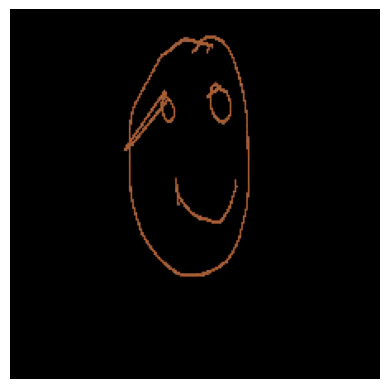

In [9]:
# Get model prediction
img_path = '/Users/gursp/Desktop/temp_image.jpg'

# reshape to (1, 224, 244, 3), normalize (div by 255.0), make image to numpy
input_image = preprocess_image(img_path)

# reshape to (224, 244, 3) for plt to work
input_image = tf.squeeze(input_image)

plt.imshow(input_image)
plt.axis('off')
plt.show()

In [ ]:
make_prediction(img_path)

In [8]:
# Initialize MediaPipe Hands and OpenCV
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Open webcam
webcam = cv2.VideoCapture(0)

# Initialize MediaPipe Hands model outside the loop
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands = 1)

# get the widht, height, and channels (RGB) of the canvas screen
width = 400
height = 400

channels = 3

canvas = np.zeros((width, height, channels), dtype=np.uint8)

# prediction by the model
prediction = ""

old_time = time.time()
last_canvas = canvas.copy()

img_threshold = 10000

# returns the distance between the tip of the index finger and the thumb
def euclidean_distance(index_x, index_y, thumb_x, thumb_y):
    return np.sqrt((index_x - thumb_x)** 2 + (index_y - thumb_y)**2)

print(old_time)
finger_coords = []
while webcam.isOpened():
    success, img = webcam.read()
    if not success:
        break  # Exit if no frame is captured

    # Convert image to RGB for processing
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    # Convert back to BGR for OpenCV display
    img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    img = cv2.flip(img, 1)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Extract index finger keypoints
            index_tip = hand_landmarks.landmark[8]   # Index fingertip
            index_dip = hand_landmarks.landmark[7]   # Distal interphalangeal joint

            thumb_tip = hand_landmarks.landmark[4] # thumb fingetip
            thumb_dip = hand_landmarks.landmark[3] # thumb interphalangeal joint
            
            # Get image dimensions
            h, w, _ = img.shape

            
            index_tip_val = (int(index_tip.x * w), int(index_tip.y * h))
            index_dip_val = (int(index_dip.x * w), int(index_dip.y * h))

            thumb_tip_val = (int(thumb_tip.x * w), int(thumb_tip.y * h))
            thumb_dip_val = (int(thumb_dip.x * w), int(thumb_dip.y * h))
            
            # Convert normalized coordinates to pixel values and flip x-coordinates
            flipped_index_tip = (w - int(index_tip.x * w), int(index_tip.y * h))
            flipped_index_dip = (w - int(index_dip.x * w), int(index_dip.y * h))

            # Convert normalized coordinates to pixel values and flip x-coordinates
            flipped_thumb_tip = (w - int(thumb_tip.x * w), int(thumb_tip.y * h))
            flipped_thumb_dip = (w - int(thumb_dip.x * w), int(thumb_dip.y * h))

            # Draw circles on index finger keypoints
            cv2.circle(img, flipped_index_tip, 8, (0, 0, 255), -1)  # Red for fingertip
            # Draw lines between index finger joints
            cv2.line(img, flipped_index_tip, flipped_index_dip, (255, 165, 0), 3)

            # Draw thumb lines
            cv2.circle(img, flipped_thumb_tip, 8, (0, 0, 255), -1)  # Draw circle on tip
            cv2.line(img, flipped_thumb_tip, flipped_thumb_dip, (255, 165, 0), 3) # draw line b/w tip and dip

            # Draw index finger lines
            cv2.circle(img, flipped_index_tip, 8, (0, 0, 255), -1)  # Draw circle on tip
            cv2.line(img, flipped_index_tip, flipped_index_dip, (255, 165, 0), 3) # draw line b/w tip and dip

            threshold_distance = 70 # in pixels

            distance = euclidean_distance(index_tip_val[0], index_tip_val[1], thumb_tip_val[0], thumb_tip_val[1])

            if distance > threshold_distance:
                # Store flipped coordinates
                finger_coords.append(index_tip_val)
            else:
                # If fingers are touching, clear the stored points to break the line
                finger_coords = []

            # Draw a line between the previous and current point
            for i in range(1, len(finger_coords)):
                cv2.line(canvas, finger_coords[i - 1], finger_coords[i], (50, 94, 168), 10) # USE BGR NOT RGB

    alpha = 1  # Weight for the first image
    beta = 1  # Weight for the second image
    

    canvas = cv2.resize(canvas, (img.shape[1], img.shape[0]))


    flipped_canvas = cv2.flip(canvas, 1)
            
    alpha = 1  # Weight for the first image
    beta = 1  # Weight for the second image
    blended_img = cv2.addWeighted(img, alpha, flipped_canvas, beta, 0)

    # check at every frame if any key is pressed
    key = cv2.waitKey(1) & 0xFF

    # Break the loop if 'q' is pressed
    if key == ord("c"):
        finger_coords = []
        flipped_canvas[:] = (0, 0, 0)
        canvas[:] = (0, 0, 0)
        last_canvas = canvas.copy()  # <<<<<<<<<< ADD THIS LINE
        prediction = ""

    if key == ord("e"):
        # print("in here")
        # Convert the canvas to the appropriate format
        canvas_img = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(canvas_img)  # Convert to PIL image
        
        img_path = "/Users/gursp/Desktop/temp_image.jpg"  # Save temporarily if needed
        pil_img.save(img_path)  # Save the image to disk
    
        # Call the make_prediction function with the saved image
        prediction = make_prediction(img_path)
        print(prediction)
    
    if key == ord("q"):
        break

    if time.time() - old_time > 3:

        if canvas.shape != last_canvas.shape:
            last_canvas = cv2.resize(last_canvas, (canvas.shape[1], canvas.shape[0]))
        
        difference = cv2.absdiff(canvas, last_canvas)

        if np.sum(difference) > img_threshold:
            canvas_img = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(canvas_img)  # Convert to PIL image
            
            img_path = "/Users/gursp/Desktop/temp_image.jpg"  # Save temporarily if needed
            pil_img.save(img_path)  # Save the image to disk
        
            # Call the make_prediction function with the saved image
            prediction = make_prediction(img_path)
            print(prediction)
        
        old_time = time.time()
        last_canvas = canvas.copy()
    
    if prediction != "":
        cv2.putText(blended_img, f'I think this is a {prediction}', (500, 1000), cv2.FONT_HERSHEY_SIMPLEX, 2.2, (255, 255, 255), 4)
    
    # Display the image
    cv2.imshow('Index Finger Tracking', blended_img)


I0000 00:00:1745709791.797901 4871470 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1745709791.817907 4999502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745709791.826235 4999502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1745709791.799558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
[[0.26008195 0.43887988 0.3010382 ]]
door
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
[[0.46733373 0.3572947  0.17537151]]
face
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[[0.53454214 0.2927182  0.17273965]]
face
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[[0.59836036 0.25452134 0.1471183 ]]
face



KeyboardInterrupt

